In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/commonlitreadabilityprize/sample_submission.csv
/kaggle/input/commonlitreadabilityprize/train.csv
/kaggle/input/commonlitreadabilityprize/test.csv
/kaggle/input/huggingface-roberta/roberta-base/rust_model.ot
/kaggle/input/huggingface-roberta/roberta-base/config.json
/kaggle/input/huggingface-roberta/roberta-base/merges.txt
/kaggle/input/huggingface-roberta/roberta-base/tokenizer.json
/kaggle/input/huggingface-roberta/roberta-base/vocab.json
/kaggle/input/huggingface-roberta/roberta-base/tf_model.h5
/kaggle/input/huggingface-roberta/roberta-base/dict.txt
/kaggle/input/huggingface-roberta/roberta-base/pytorch_model.bin
/kaggle/input/huggingface-roberta/roberta-base/flax_model.msgpack
/kaggle/input/huggingface-roberta/roberta-large/config.json
/kaggle/input/huggingface-roberta/roberta-large/merges.txt
/kaggle/input/huggingface-roberta/roberta-large/tokenizer.json
/kaggle/input/huggingface-roberta/roberta-large/vocab.json
/kaggle/input/huggingface-roberta/roberta-large/tf_mod

In [2]:
from transformers import AutoTokenizer
from transformers import TFAutoModel
import tensorflow as tf

In [3]:
print(tf.test.is_gpu_available())

True


In [4]:
LEARNING_RATE = 1e-5 
ES_PATIENCE = 7
PATIENCE = 2
EPOCHS = 10
SEQ_LEN = 256
BATCH_SIZE = 16

In [5]:
CHECKPOINT = '/kaggle/input/huggingface-roberta/roberta-base/'
tokenizer = AutoTokenizer.from_pretrained(CHECKPOINT)
base_model = TFAutoModel.from_pretrained(CHECKPOINT)

Some layers from the model checkpoint at /kaggle/input/huggingface-roberta/roberta-base/ were not used when initializing TFRobertaModel: ['lm_head']
- This IS expected if you are initializing TFRobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFRobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFRobertaModel were initialized from the model checkpoint at /kaggle/input/huggingface-roberta/roberta-base/.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFRobertaModel for predictions without further training.


In [6]:
import pandas as pd

def load_data():
    train_filepath = '/kaggle/input/commonlitreadabilityprize/train.csv'
    test_filepath = '/kaggle/input/commonlitreadabilityprize/test.csv'

    train = pd.read_csv(train_filepath)
    test = pd.read_csv(test_filepath)

    # removing unused columns
    train = train.drop(['url_legal', 'license'], axis=1)
    test = test.drop(['url_legal', 'license'], axis=1)
    return train, test

In [7]:
train, test = load_data()

In [8]:
class CustomRoberta(tf.keras.Model):
    def __init__(self, embedding_dim):
        super(CustomRoberta, self).__init__()
        self.embedding_dim = embedding_dim
        self.dropout = tf.keras.layers.Dropout(0.5)
        self.dense = tf.keras.layers.Dense(
            1, input_shape=(embedding_dim,), activation=None, name="dense_last_layer"
        )
        self.bert_layer = TFAutoModel.from_pretrained(CHECKPOINT)

    def call(self, input_ids, attention_mask):
        sequence = self.bert_layer(input_ids, attention_mask)[0]
        x = sequence[:, 0, :]
        x = self.dropout(x)
        x = self.dense(x)
        return x

In [9]:
# Datasets utility functions
def custom_standardization(text):
    text = text.lower() # if encoder is uncased
    text = text.strip()
    return text

def convert_raw_dataframe_to_tf_dataset(df: pd.DataFrame, tokenizer: AutoTokenizer, labeled: bool =True, ordered: bool =False, repeated: bool =False, 
                is_sampled: bool =False, batch_size: int =32, seq_len: int =128):
    """
        Return a Tensorflow dataset ready for training or inference.
    """
    text = [custom_standardization(text) for text in df['excerpt']]
    
    # Tokenize inputs
    tokenized_inputs = tokenizer(text, max_length=seq_len, truncation=True, 
                                 padding='max_length', return_tensors='tf')
    
    if labeled:
        dataset = tf.data.Dataset.from_tensor_slices(({'input_ids': tokenized_inputs['input_ids'], 
                                                      'attention_mask': tokenized_inputs['attention_mask']}, 
                                                      (df['target'], df['standard_error'])))
        if is_sampled:
            dataset = dataset.map(sample_target, num_parallel_calls=tf.data.AUTOTUNE)
    else:
        dataset = tf.data.Dataset.from_tensor_slices({'input_ids': tokenized_inputs['input_ids'], 
                                                      'attention_mask': tokenized_inputs['attention_mask']})
        
    if repeated:
        dataset = dataset.repeat()
    if not ordered:
        dataset = dataset.shuffle(1024)
    dataset = dataset.batch(batch_size)
    dataset = dataset.prefetch(tf.data.AUTOTUNE)
    
    return dataset

In [10]:
def build_model(encoder, seq_len=256):
    input_ids = tf.keras.layers.Input(shape=(seq_len,), dtype=tf.int32, name='input_ids')
    input_attention_mask = tf.keras.layers.Input(shape=(seq_len,), dtype=tf.int32, name='attention_mask')
    
    outputs = encoder(input_ids=input_ids, attention_mask = input_attention_mask)
    
    model = tf.keras.Model(inputs=[input_ids, input_attention_mask], outputs=outputs)

    optimizer = tf.keras.optimizers.Adam(lr=LEARNING_RATE)
    model.compile(optimizer=optimizer, 
                  loss=tf.keras.losses.MeanSquaredError(), 
                  metrics=[tf.keras.metrics.RootMeanSquaredError()])
    
    return model

In [11]:
encoder = CustomRoberta(embedding_dim=238)

Some layers from the model checkpoint at /kaggle/input/huggingface-roberta/roberta-base/ were not used when initializing TFRobertaModel: ['lm_head']
- This IS expected if you are initializing TFRobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFRobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFRobertaModel were initialized from the model checkpoint at /kaggle/input/huggingface-roberta/roberta-base/.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFRobertaModel for predictions without further training.


In [12]:
model = build_model(encoder, seq_len=256)

In [13]:
MODEL_PATH = 'model.h5'
checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(MODEL_PATH, monitor='val_root_mean_squared_error', mode='min', 
                             save_best_only=True, save_weights_only=True)

In [14]:
train = train.sample(train.shape[0])
train_df = train.iloc[:int(0.75*train.shape[0])]
val_df = train.iloc[int(0.75*train.shape[0]):]
training_dataset = convert_raw_dataframe_to_tf_dataset(train_df, tokenizer, seq_len=SEQ_LEN, batch_size=BATCH_SIZE)
validation_dataset = convert_raw_dataframe_to_tf_dataset(val_df, tokenizer, seq_len=SEQ_LEN, batch_size=BATCH_SIZE)

In [15]:
history = model.fit(x=training_dataset, 
                    validation_data=validation_dataset, 
                   # steps_per_epoch=50, 
                    callbacks=[checkpoint_callback], 
                    epochs=EPOCHS,  
                    verbose=1).history

Epoch 1/10
133/133 [==============================] - 92s 582ms/step - loss: 2.2488 - root_mean_squared_error: 1.4902 - val_loss: 0.4035 - val_root_mean_squared_error: 0.6352
Epoch 2/10
133/133 [==============================] - 74s 557ms/step - loss: 1.2113 - root_mean_squared_error: 1.0997 - val_loss: 0.4865 - val_root_mean_squared_error: 0.6975
Epoch 3/10
133/133 [==============================] - 74s 557ms/step - loss: 0.8428 - root_mean_squared_error: 0.9172 - val_loss: 0.4166 - val_root_mean_squared_error: 0.6454
Epoch 4/10
133/133 [==============================] - 74s 557ms/step - loss: 0.6495 - root_mean_squared_error: 0.8056 - val_loss: 0.3644 - val_root_mean_squared_error: 0.6036
Epoch 5/10
133/133 [==============================] - 74s 558ms/step - loss: 0.5237 - root_mean_squared_error: 0.7231 - val_loss: 0.4850 - val_root_mean_squared_error: 0.6964
Epoch 6/10
133/133 [==============================] - 74s 557ms/step - loss: 0.4494 - root_mean_squared_error: 0.6701 - val_l

In [16]:
model.load_weights(MODEL_PATH)

In [17]:
print(f"#### OOF RMSE = {np.min(history['val_root_mean_squared_error']):.4f}")

#### OOF RMSE = 0.6036


In [18]:
import seaborn as sns
from matplotlib import pyplot as plt

def plot_metrics(history):
    metric_list = list(history.keys())
    size = len(metric_list)//2
    fig, axes = plt.subplots(size, 1, sharex='col', figsize=(20, size * 5))
    axes = axes.flatten()
    
    for index in range(len(metric_list)//2):
        metric_name = metric_list[index]
        val_metric_name = metric_list[index+size]
        axes[index].plot(history[metric_name], label='Train %s' % metric_name)
        axes[index].plot(history[val_metric_name], label='Validation %s' % metric_name)
        axes[index].legend(loc='best', fontsize=16)
        axes[index].set_title(metric_name)

    plt.xlabel('Epochs', fontsize=16)
    sns.despine()
    plt.show()

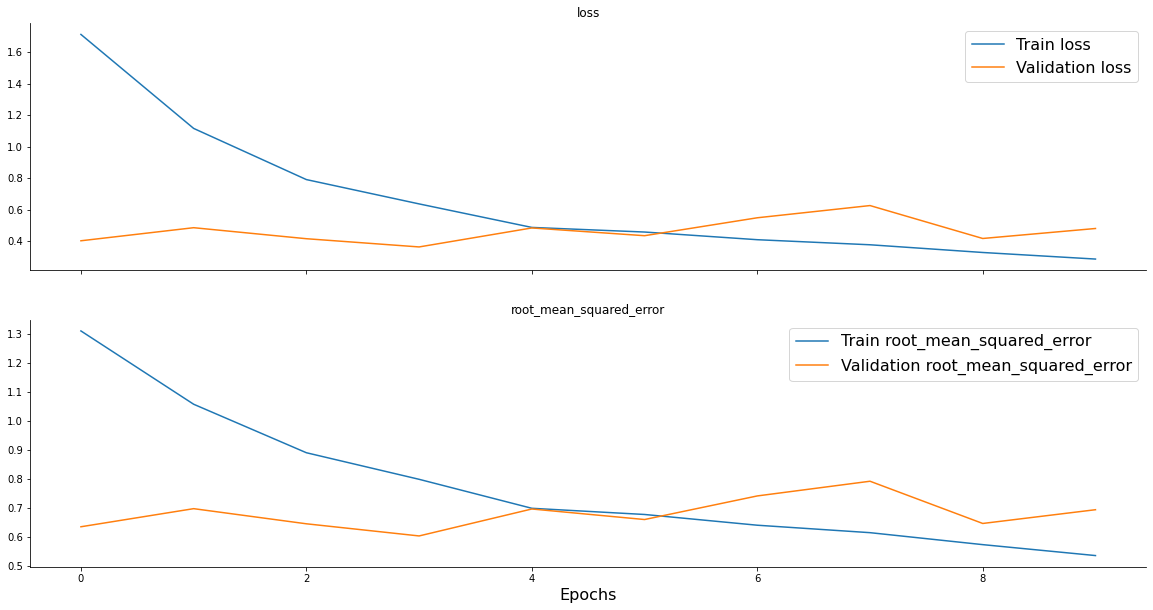

In [19]:
 plot_metrics(history)

In [20]:
test_dataset = convert_raw_dataframe_to_tf_dataset(test, tokenizer, labeled=False, ordered=True, batch_size=BATCH_SIZE, seq_len=SEQ_LEN)
x_test = test_dataset.map(lambda sample: sample)
test_pred = model.predict(x_test)

In [21]:
submission = pd.DataFrame({'id':test.id,'target':test_pred.flatten()})    
submission.to_csv('/kaggle/working/submission.csv',index=False)